## 实战练习之一 AI股票拟合算法

In [ ]:
#print?
#!python -V
!pip list

### 输入必要的库

In [31]:
%matplotlib inline


import pandas            as pd
import tensorflow        as tf  
import numpy             as np
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

from numpy                 import array
from sklearn               import metrics
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models          import Sequential
from tensorflow.keras.layers          import Dense,LSTM,Bidirectional

from numpy.random   import seed



In [32]:
np.__path__

['c:\\ProgramData\\Anaconda3\\envs\\python310\\lib\\site-packages\\numpy']

In [36]:
#np.__all__
#np.__dict__
np.__doc__
#np.__file__
#np.__package__

'\nNumPy\n=====\n\nProvides\n  1. An array object of arbitrary homogeneous items\n  2. Fast mathematical operations over arrays\n  3. Linear Algebra, Fourier Transforms, Random Number Generation\n\nHow to use the documentation\n----------------------------\nDocumentation is available in two forms: docstrings provided\nwith the code, and a loose standing reference guide, available from\n`the NumPy homepage <https://www.scipy.org>`_.\n\nWe recommend exploring the docstrings using\n`IPython <https://ipython.org>`_, an advanced Python shell with\nTAB-completion and introspection capabilities.  See below for further\ninstructions.\n\nThe docstring examples assume that `numpy` has been imported as `np`::\n\n  >>> import numpy as np\n\nCode snippets are indicated by three greater-than signs::\n\n  >>> x = 42\n  >>> x = x + 1\n\nUse the built-in ``help`` function to view a function\'s docstring::\n\n  >>> help(np.sort)\n  ... # doctest: +SKIP\n\nFor some objects, ``np.info(obj)`` may provide a

### 导入股票模块

In [37]:
# 导入tushare
import tushare as ts

### Tushare 初始化

In [38]:
#pro=ts.get_hist_data('603722')
help(ts.pro_api)

Help on function pro_api in module tushare.pro.data_pro:

pro_api(token='', timeout=30)
    初始化pro API,第一次可以通过ts.set_token('your token')来记录自己的token凭证，临时token可以通过本参数传入



### A股日线行情

接口：daily，可以通过数据工具调试和查看数据   
数据说明：交易日每天15点～16点之间入库。本接口是未复权行情，停牌期间不提供数据   
调取说明：120积分每分钟内最多调取500次，每次6000条数据，相当于单次提取23年历史   
描述：获取股票行情数据，或通过通用行情接口获取数据，包含了前后复权数据   

<p><strong>输入参数</strong></p>
<table>
<thead>
<tr>
<th>名称</th>
<th>类型</th>
<th>必选</th>
<th>描述</th>
</tr>
</thead>
<tbody><tr>
<td>ts_code</td>
<td>str</td>
<td>N</td>
<td>股票代码（支持多个股票同时提取，逗号分隔）</td>
</tr>
<tr>
<td>trade_date</td>
<td>str</td>
<td>N</td>
<td>交易日期（YYYYMMDD）</td>
</tr>
<tr>
<td>start_date</td>
<td>str</td>
<td>N</td>
<td>开始日期(YYYYMMDD)</td>
</tr>
<tr>
<td>end_date</td>
<td>str</td>
<td>N</td>
<td>结束日期(YYYYMMDD)</td>
</tr>
</tbody>
</table>


<p><strong>注：日期都填YYYYMMDD格式，比如20181010</strong></p>
<p><strong>输出参数</strong></p>
<table>
<thead>
<tr>
<th>名称</th>
<th>类型</th>
<th>描述</th>
</tr>
</thead>
<tbody><tr>
<td>ts_code</td>
<td>str</td>
<td>股票代码</td>
</tr>
<tr>
<td>trade_date</td>
<td>str</td>
<td>交易日期</td>
</tr>
<tr>
<td>open</td>
<td>float</td>
<td>开盘价</td>
</tr>
<tr>
<td>high</td>
<td>float</td>
<td>最高价</td>
</tr>
<tr>
<td>low</td>
<td>float</td>
<td>最低价</td>
</tr>
<tr>
<td>close</td>
<td>float</td>
<td>收盘价</td>
</tr>
<tr>
<td>pre_close</td>
<td>float</td>
<td>昨收价(前复权)</td>
</tr>
<tr>
<td>change</td>
<td>float</td>
<td>涨跌额</td>
</tr>
<tr>
<td>pct_chg</td>
<td>float</td>
<td>涨跌幅 （未复权，如果是复权请用 <a href="https://tushare.pro/document/2?doc_id=109">通用行情接口</a> ）</td>
</tr>
<tr>
<td>vol</td>
<td>float</td>
<td>成交量 （手）</td>
</tr>
<tr>
<td>amount</td>
<td>float</td>
<td>成交额 （千元）</td>
</tr>
</tbody></table>



In [39]:

# 导入tushare
import tushare as ts
# 初始化pro接口
pro = ts.pro_api('134e2799d5b514483218d281d17de3a78bff4bbbf996cb9711227cac')

# 拉取数据
df = pro.daily(**{
    "ts_code": "002896.SZ",
    "trade_date": "",
    "start_date": 20100101,
    "end_date": 20231025,
    "offset": "",
    "limit": ""
}, fields=[
    "ts_code",
    "trade_date",
    "open",
    "high",
    "low",
    "close",
    "pre_close",
    "change",
    "pct_chg",
    "vol",
    "amount"
])
print(df)

        ts_code trade_date   open   high    low  close  pre_close  change  \
0     002896.SZ   20231025  33.28  36.25  33.22  34.49      32.95    1.54   
1     002896.SZ   20231024  32.75  34.32  32.58  32.95      32.75    0.20   
2     002896.SZ   20231023  33.71  34.02  32.25  32.75      34.06   -1.31   
3     002896.SZ   20231020  35.35  36.35  33.80  34.06      35.82   -1.76   
4     002896.SZ   20231019  35.61  36.20  35.10  35.82      35.61    0.21   
...         ...        ...    ...    ...    ...    ...        ...     ...   
1487  002896.SZ   20170904  24.77  24.77  24.77  24.77      22.52    2.25   
1488  002896.SZ   20170901  22.52  22.52  22.52  22.52      20.47    2.05   
1489  002896.SZ   20170831  20.47  20.47  20.47  20.47      18.61    1.86   
1490  002896.SZ   20170830  18.61  18.61  18.61  18.61      16.92    1.69   
1491  002896.SZ   20170829  15.51  16.92  15.51  16.92      11.75    5.17   

      pct_chg        vol      amount  
0      4.6737  132801.00  464876.948

In [51]:
### 存储数据
print(df)
df.to_csv("stock002896.csv")
df.to_excel("stock002896.xlsx")


        ts_code trade_date   open   high    low  close  pre_close  change  \
0     002896.SZ   20231025  33.28  36.25  33.22  34.49      32.95    1.54   
1     002896.SZ   20231024  32.75  34.32  32.58  32.95      32.75    0.20   
2     002896.SZ   20231023  33.71  34.02  32.25  32.75      34.06   -1.31   
3     002896.SZ   20231020  35.35  36.35  33.80  34.06      35.82   -1.76   
4     002896.SZ   20231019  35.61  36.20  35.10  35.82      35.61    0.21   
...         ...        ...    ...    ...    ...    ...        ...     ...   
1487  002896.SZ   20170904  24.77  24.77  24.77  24.77      22.52    2.25   
1488  002896.SZ   20170901  22.52  22.52  22.52  22.52      20.47    2.05   
1489  002896.SZ   20170831  20.47  20.47  20.47  20.47      18.61    1.86   
1490  002896.SZ   20170830  18.61  18.61  18.61  18.61      16.92    1.69   
1491  002896.SZ   20170829  15.51  16.92  15.51  16.92      11.75    5.17   

      pct_chg        vol      amount  
0      4.6737  132801.00  464876.948

In [42]:
#数据转置
df.T

0          1           2           3           4     \
ts_code      002896.SZ  002896.SZ   002896.SZ   002896.SZ   002896.SZ   
trade_date    20231025   20231024    20231023    20231020    20231019   
open             33.28      32.75       33.71       35.35       35.61   
high             36.25      34.32       34.02       36.35        36.2   
low              33.22      32.58       32.25        33.8        35.1   
close            34.49      32.95       32.75       34.06       35.82   
pre_close        32.95      32.75       34.06       35.82       35.61   
change            1.54        0.2       -1.31       -1.76        0.21   
pct_chg         4.6737     0.6107     -3.8462     -4.9135      0.5897   
vol           132801.0   80978.03     75142.2    75855.89     59515.0   
amount      464876.948   269829.7  247467.441  263989.558  211937.608   

                  5           6           7           8           9     ...  \
ts_code      002896.SZ   002896.SZ   002896.SZ   002896.SZ   002896.SZ  ...   
trade_date    20231018    20231017    20231016    20231013    20231012  ...   
open             36.09       37.31       37.42       38.52       39.09  ...   
high             36.49        37.8       38.96       39.14        40.3  ...   
low               35.5       35.11        37.0        37.4        38.3  ...   
close            35.61       36.45       38.06       37.42        38.8  ...   
pre_close        36.45       38.06       37.42        38.8       39.45  ...   
change           -0.84       -1.61        0.64       -1.38       -0.65  ...   
pct_chg        -2.3045     -4.2302      1.7103     -3.5567     -1.6477  ...   
vol           55764.69     99718.3   104992.73    111398.0   136569.47  ...   
amount      200194.982  361372.791  399899.602  425743.454  532754.049  ...   

                 1482       1483       1484       1485       1486       1487  \
ts_code     002896.SZ  002896.SZ  002896.SZ  002896.SZ  002896.SZ  002896.SZ   
trade_date   20170913   20170908   20170907   20170906   20170905   20170904   
open            39.91      36.28      32.98      29.98      27.25      24.77   
high            39.91      36.28      32.98      29.98      27.25      24.77   
low             39.91      36.28      32.98      29.98      27.25      24.77   
close           39.91      36.28      32.98      29.98      27.25      24.77   
pre_close       36.28      32.98      29.98      27.25      24.77      22.52   
change           3.63        3.3        3.0       2.73       2.48       2.25   
pct_chg         10.01      10.01      10.01      10.02      10.01       9.99   
vol           1586.15     924.71      469.7      118.0      114.0       74.0   
amount       6330.324   3354.847    1549.07    353.764     310.65    183.298   

                 1488       1489       1490       1491  
ts_code     002896.SZ  002896.SZ  002896.SZ  002896.SZ  
trade_date   20170901   20170831   20170830   20170829  
open            22.52      20.47      18.61      15.51  
high            22.52      20.47      18.61      16.92  
low             22.52      20.47      18.61      15.51  
close           22.52      20.47      18.61      16.92  
pre_close       20.47      18.61      16.92      11.75  
change           2.05       1.86       1.69       5.17  
pct_chg         10.01       9.99       9.99       44.0  
vol              54.0       36.0       26.0       75.0  
amount        121.608     73.692     48.386    126.618  

[11 rows x 1492 columns]

<AxesSubplot:>

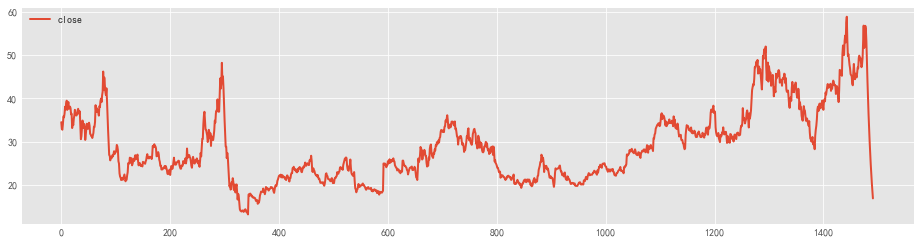

In [43]:
#输出图形
df["close"].plot(figsize=(16,4),legend=True)  

In [57]:
#读取数据
mydata=pd.read_csv("./stock002896.csv",parse_dates=["trade_date"],index_col="trade_date")[["open","high","low","close"]]
#pmydata=pd.read_csv("./stock300337.csv",parse_dates=["trade_date"],index_col="trade_date")

# data=pd.read_csv("./stock688333.csv",parse_dates=["trade_date"])[["trade_date","open","high","low","close","vol"]]

#翻转数据

mydata=mydata.iloc[::-1]

#plt.plot(mydata["close"])
#mydata["close"].plot(figsize=(16,4),legend=True)
mydata

open   high    low  close
trade_date                            
2017-08-29  15.51  16.92  15.51  16.92
2017-08-30  18.61  18.61  18.61  18.61
2017-08-31  20.47  20.47  20.47  20.47
2017-09-01  22.52  22.52  22.52  22.52
2017-09-04  24.77  24.77  24.77  24.77
...           ...    ...    ...    ...
2023-10-19  35.61  36.20  35.10  35.82
2023-10-20  35.35  36.35  33.80  34.06
2023-10-23  33.71  34.02  32.25  32.75
2023-10-24  32.75  34.32  32.58  32.95
2023-10-25  33.28  36.25  33.22  34.49

[1492 rows x 4 columns]

In [58]:
# 获取股价数据
import pandas as pd
import numpy as np
# import akshare as ak


df3 = mydata.reset_index().iloc[30:, :6]  # 取过去30天数据
df3 = df3.dropna(how='any').reset_index(drop=True) #去除空值且从零开始编号索引
df3 = df3.sort_values(by='trade_date', ascending=True)
print(df3.info())

# 计算均线数据
df3['5'] = df3.close.rolling(5).mean()
df3['10'] = df3.close.rolling(10).mean()

df3.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   trade_date  1462 non-null   datetime64[ns]
 1   open        1462 non-null   float64       
 2   high        1462 non-null   float64       
 3   low         1462 non-null   float64       
 4   close       1462 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 68.5 KB
None


trade_date   open   high    low  close       5      10
1457 2023-10-19  35.61  36.20  35.10  35.82  36.672  37.611
1458 2023-10-20  35.35  36.35  33.80  34.06  36.000  37.103
1459 2023-10-23  33.71  34.02  32.25  32.75  34.938  36.575
1460 2023-10-24  32.75  34.32  32.58  32.95  34.238  36.137
1461 2023-10-25  33.28  36.25  33.22  34.49  34.014  35.641

c:\ProgramData\Anaconda3\envs\python310\lib\site-packages\mplfinance\_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


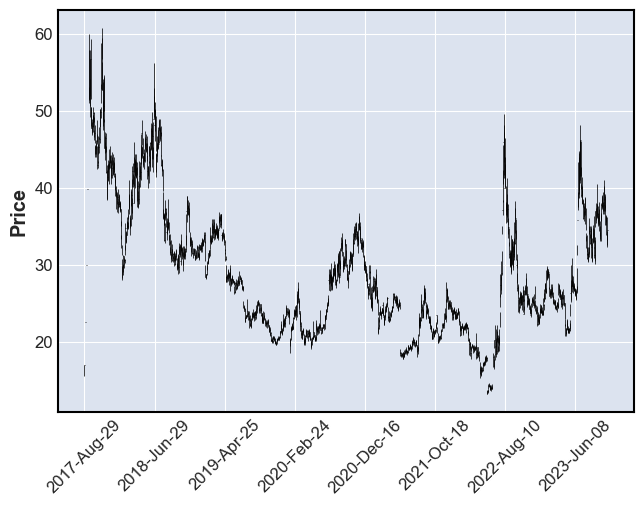

In [59]:
import matplotlib
matplotlib.style.use('ggplot') #用于调整图标样式，可选
import matplotlib.pyplot as plt
import mplfinance as mpf
from mplfinance.original_flavor import candlestick2_ohlc
from matplotlib.ticker import FormatStrFormatter
mpf.plot(mydata)


C:\Users\zeng_\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 38134 (\N{CJK UNIFIED IDEOGRAPH-94F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\zeng_\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 37030 (\N{CJK UNIFIED IDEOGRAPH-90A6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\zeng_\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\zeng_\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


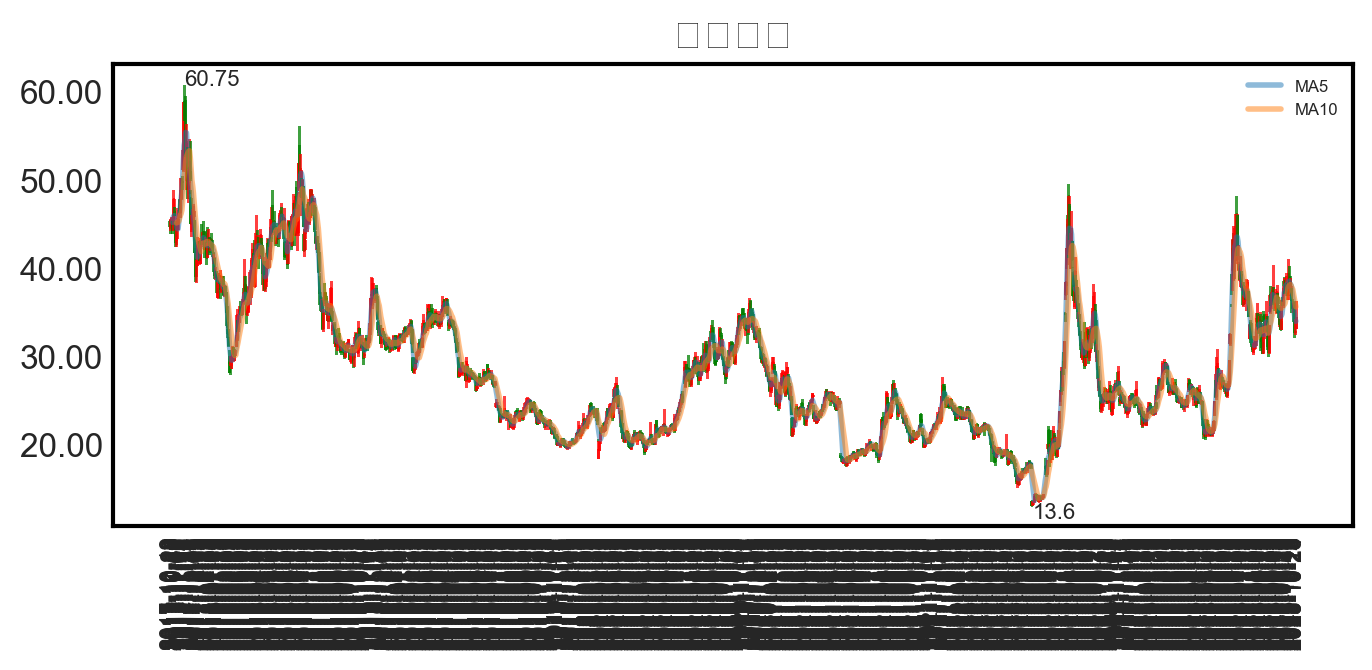

In [60]:

fig, ax = plt.subplots(1, 1, figsize=(8,3), dpi=200)

candlestick2_ohlc(ax,
                  opens = df3[ 'open'].values,
                highs = df3['high'].values,
                lows = df3[ 'low'].values,
                closes = df3['close'].values,
                  width=0.5, colorup="r",colordown="g")

# 显示最高点和最低点
ax.text( df3.high.idxmax(), df3.high.max(),   s =df3.high.max(), fontsize=8)
ax.text( df3.high.idxmin(), df3.high.min()-2, s = df3.high.min(), fontsize=8)

ax.set_facecolor("white")
ax.set_title("银邦股份")

# 画均线
plt.plot(df3['5'].values, alpha = 0.5, label='MA5')
plt.plot(df3['10'].values, alpha = 0.5, label='MA10')

ax.legend(facecolor='white', edgecolor='white', fontsize=6)

# 修改x轴坐标
plt.xticks(ticks =  np.arange(0,len(df3)), labels = df3.trade_date.dt.strftime('%Y-%m-%d').to_numpy() )
plt.xticks(rotation=90, size=8)

# 修改y轴坐标
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.show()

In [ ]:
#from matplotlib.dates  import date2num
#data['date']=date2num(data.index.to_pydatetime())
#data=data.sort_values(by="date",ascending=True)
data

In [61]:
# 获取股价数据
import pandas as pd
import numpy as np

df3 = mydata.reset_index().iloc[:,:]  #取过去30天数据
df3 = df3.dropna(how='any').reset_index(drop=True) #去除空值且从零开始编号索引
print(df3)
df3 = df3.sort_values(by='trade_date', ascending=True)
print(df3.info())

# 均线数据
df3['5'] = df3.close.rolling(5).mean()
df3['10'] = df3.close.rolling(10).mean()
df3['30']=df3.close.rolling(30).mean()

df3

     trade_date   open   high    low  close
0    2017-08-29  15.51  16.92  15.51  16.92
1    2017-08-30  18.61  18.61  18.61  18.61
2    2017-08-31  20.47  20.47  20.47  20.47
3    2017-09-01  22.52  22.52  22.52  22.52
4    2017-09-04  24.77  24.77  24.77  24.77
...         ...    ...    ...    ...    ...
1487 2023-10-19  35.61  36.20  35.10  35.82
1488 2023-10-20  35.35  36.35  33.80  34.06
1489 2023-10-23  33.71  34.02  32.25  32.75
1490 2023-10-24  32.75  34.32  32.58  32.95
1491 2023-10-25  33.28  36.25  33.22  34.49

[1492 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1492 entries, 0 to 1491
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   trade_date  1492 non-null   datetime64[ns]
 1   open        1492 non-null   float64       
 2   high        1492 non-null   float64       
 3   low         1492 non-null   float64       
 4   close       1492 non-null   float64       
dtype

trade_date   open   high    low  close       5      10         30
0    2017-08-29  15.51  16.92  15.51  16.92     NaN     NaN        NaN
1    2017-08-30  18.61  18.61  18.61  18.61     NaN     NaN        NaN
2    2017-08-31  20.47  20.47  20.47  20.47     NaN     NaN        NaN
3    2017-09-01  22.52  22.52  22.52  22.52     NaN     NaN        NaN
4    2017-09-04  24.77  24.77  24.77  24.77  20.658     NaN        NaN
...         ...    ...    ...    ...    ...     ...     ...        ...
1487 2023-10-19  35.61  36.20  35.10  35.82  36.672  37.611  36.771667
1488 2023-10-20  35.35  36.35  33.80  34.06  36.000  37.103  36.694000
1489 2023-10-23  33.71  34.02  32.25  32.75  34.938  36.575  36.555667
1490 2023-10-24  32.75  34.32  32.58  32.95  34.238  36.137  36.401333
1491 2023-10-25  33.28  36.25  33.22  34.49  34.014  35.641  36.311000

[1492 rows x 8 columns]

C:\Users\zeng_\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 38134 (\N{CJK UNIFIED IDEOGRAPH-94F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\zeng_\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 37030 (\N{CJK UNIFIED IDEOGRAPH-90A6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\zeng_\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\zeng_\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


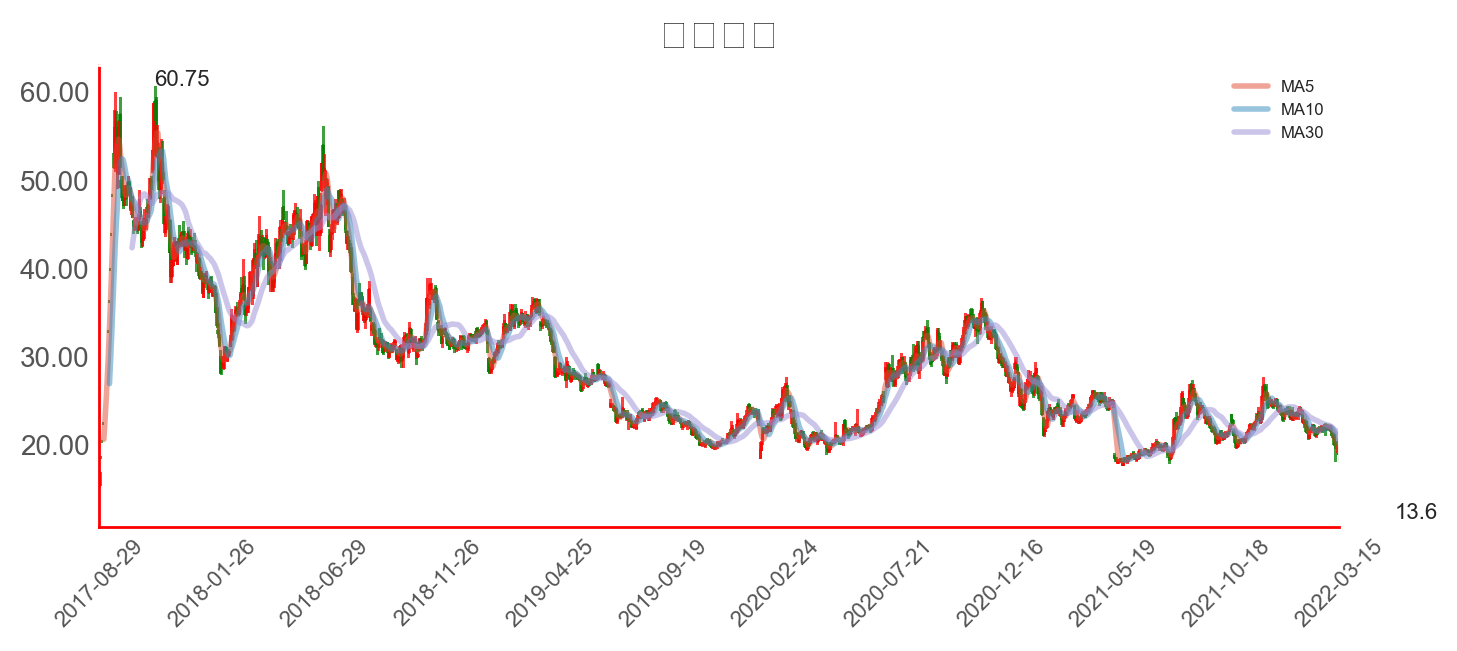

In [62]:
import matplotlib
matplotlib.style.use('ggplot') #用于调整图标样式，可选
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick2_ohlc
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(1, 1, figsize=(8,3), dpi=200)

candlestick2_ohlc(ax,
                  opens = df3[ 'open'].values,
                highs = df3['high'].values,
                lows = df3[ 'low'].values,
                closes = df3['close'].values,
                  width=0.5, colorup="r",colordown="g")

# 显示最高点和最低点
ax.text( df3.high.idxmax(), df3.high.max(),   s =df3.high.max(), fontsize=8)
ax.text( df3.high.idxmin(), df3.high.min()-2, s = df3.high.min(), fontsize=8)

ax.set_facecolor("white")
ax.set_title("银邦股份")

# 画均线
plt.plot(df3['5'].values, alpha = 0.5, label='MA5')
plt.plot(df3['10'].values, alpha = 0.5, label='MA10')
plt.plot(df3['30'].values,alpha=0.5, label='MA30')

ax.legend(facecolor='white', edgecolor='white', fontsize=6)

# 修改x轴坐标
tempXticks=np.arange(0,len(df3))
#XticksData=data.asfreq("2M").dropna()
nameXticks =  df3.trade_date.dt.strftime('%Y-%m-%d').to_numpy()

plt.xticks(ticks =tempXticks , labels =nameXticks )
plt.xticks(rotation=45, size=8)
#修改X轴间隔
x_major_locator=plt.MultipleLocator(100)
ax.xaxis.set_major_locator(x_major_locator)
ax.spines['bottom'].set_color('red')
ax.spines['left'].set_color('red')
plt.xlim(0,1100)
# 修改y轴坐标
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.show()

In [ ]:

a=np.linspace(0,round(len(df3),0),10,dtype=int).tolist()
b=df3.trade_date.dt.strftime('%Y-%m-%d').to_numpy()
c=data.asfreq("2M").dropna()
#c.dropna().index
cc=c.index.strftime('%Y-%m-%d').to_numpy()
e=df3.trade_date.tolist()
#f=[e[i] for i in cc]
cc

In [ ]:
# data1=pd.DataFrame(data,columns=["trade_date","close"])
#data1=pd.DataFrame(data,columns=["close"])
data1=mydata
data1["open"].plot(label="open")
data1["close"].plot(label="close")
plt.legend()
plt.show()


In [ ]:
ddd=[]
for item in data1.items():
    ddd.append(item)
ind=ddd[0][1].values
da1=ddd[1][1].values
index1=[]
data2=[]
for item in ind:
    index1.append(item)
index1.reverse()
for item in da1:
    data2.append(item)
data2.reverse()
data1={'trade_date':index1,'close':data2}
stockdata=pd.DataFrame(data1)

stockdata.items    

In [65]:
#数据检查
df3.iloc[:,4:5].values[:,:]

array([[16.92],
       [18.61],
       [20.47],
       ...,
       [32.75],
       [32.95],
       [34.49]])

In [67]:
from matplotlib.dates  import date2num
date2num(df3.trade_date.values)
#添加data数据列
df3['date']=date2num(df3.trade_date.values)
#df3=df3.sort_values(by="date",ascending=True)
#df3=df3[['date','open', 'high', 'low', 'close']]

ind=np.arange(0,1491)
dataf1=df3[['date','open', 'high', 'low', 'close']]

In [68]:
dataf1.set_index("date")

open   high    low  close
date                               
17407.0  15.51  16.92  15.51  16.92
17408.0  18.61  18.61  18.61  18.61
17409.0  20.47  20.47  20.47  20.47
17410.0  22.52  22.52  22.52  22.52
17413.0  24.77  24.77  24.77  24.77
...        ...    ...    ...    ...
19649.0  35.61  36.20  35.10  35.82
19650.0  35.35  36.35  33.80  34.06
19653.0  33.71  34.02  32.25  32.75
19654.0  32.75  34.32  32.58  32.95
19655.0  33.28  36.25  33.22  34.49

[1492 rows x 4 columns]

## 深度学习拟合股票

In [ ]:
# 确保结果尽可能重现

seed(1)
tf.random.set_seed(1)

# 设置相关参数
n_timestamp  = 5    # 时间戳
n_epochs     = 30    # 训练轮数
# ====================================
#      选择模型：
#            1: 单层 LSTM
#            2: 多层 LSTM
#            3: 双向 LSTM
# ====================================
model_type = 1

### 拟合开始，数据准备

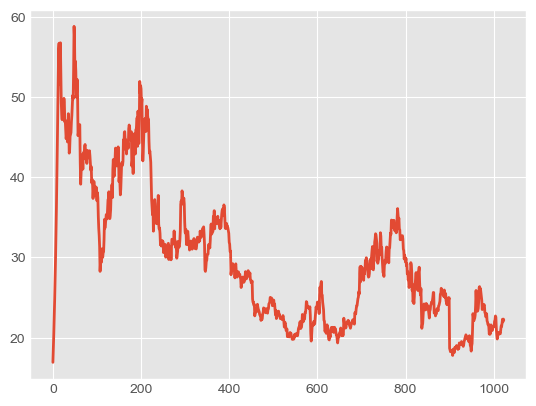

In [69]:
#
#拟合开始
#
training_set = dataf1.iloc[0:1024, 4:5].to_numpy()#要提取一列数据，否则会出错
test_set     = dataf1.iloc[1491 - 300:, 4:5].to_numpy()
#print(training_set)
plt.plot(training_set)

### 数据归一化

In [ ]:
#将数据归一化，范围是0到1
sc  = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled  = sc.transform(test_set) 


### 数据分割

In [ ]:
# 取前 n_timestamp 天的数据为 X；n_timestamp+1天数据为 Y。
def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp
        
        if end_ix > len(sequence)-1:
            break
            
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

X_train, y_train = data_split(training_set_scaled, n_timestamp)


### 训练数据重整

In [ ]:
X_train          = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test, y_test   = data_split(testing_set_scaled, n_timestamp)
X_test           = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


### 构建模型

In [ ]:
#五、构建模型
# 建构 LSTM模型
model_type=2
if model_type == 1:
    # 单层 LSTM
    model = Sequential()
    model.add(LSTM(units=50, activation='relu',
                   input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
if model_type == 2:
    # 多层 LSTM
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', return_sequences=True,
                   input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50, activation='relu'))
    model.add(Dense(1))
if model_type == 3:
    # 双向 LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'),
                            input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))

model.summary()  # 输出模型结构

### 模型编译

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差


### 训练模型

In [ ]:

#七、训练模型
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=n_epochs,
                    validation_data=(X_test, y_test),
                    validation_freq=1)  # 测试的epoch间隔数

model.summary()

### 输出训练结果

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### 模型预测

In [ ]:
predicted_stock_price = model.predict(
    X_test)                        # 测试集输入模型进行预测
predicted_stock_price = sc.inverse_transform(
    predicted_stock_price)  # 对预测数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(y_test)  # 对真实数据还原---从（0，1）反归一化到原始范围

In [ ]:
# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('银邦股份')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### 模型校核

In [ ]:
MSE = metrics.mean_squared_error(predicted_stock_price, real_stock_price)
RMSE = metrics.mean_squared_error(predicted_stock_price, real_stock_price)**0.5
MAE = metrics.mean_absolute_error(predicted_stock_price, real_stock_price)
R2 = metrics.r2_score(predicted_stock_price, real_stock_price)

print('均方误差: %.5f' % MSE)
print('均方根误差: %.5f' % RMSE)
print('平均绝对误差: %.5f' % MAE)
print('R2: %.5f' % R2)

## Yahoo Finance 数据

Great! Here’s how you can do it:

+ First, you need to install the yfinance package which is a popular Python library for downloading historical market data from Yahoo Finance. You can install it by running this command in your terminal or command prompt:

In [ ]:
!pip install yfinance --upgrade --no-cache-dir

In [ ]:
import yfinance as yf

msft = yf.Ticker("MSFT")


In [ ]:

# get all stock info
myinfo=msft.info
myinfo

In [ ]:

# get historical market data
hist = msft.history(period="1mo")


In [ ]:

# show meta information about the history (requires history() to be called first)
msft.history_metadata

# show actions (dividends, splits, capital gains)
msft.actions
msft.dividends
msft.splits
msft.capital_gains  # only for mutual funds & etfs

# show share count
msft.get_shares_full(start="2022-01-01", end=None)

# show financials:
# - income statement
msft.income_stmt
msft.quarterly_income_stmt
# - balance sheet
msft.balance_sheet
msft.quarterly_balance_sheet
# - cash flow statement
msft.cashflow
msft.quarterly_cashflow
# see `Ticker.get_income_stmt()` for more options

# show holders
msft.major_holders
msft.institutional_holders
msft.mutualfund_holders

# Show future and historic earnings dates, returns at most next 4 quarters and last 8 quarters by default. 
# Note: If more are needed use msft.get_earnings_dates(limit=XX) with increased limit argument.
msft.earnings_dates

# show ISIN code - *experimental*
# ISIN = International Securities Identification Number
msft.isin

# show options expirations
msft.options

# show news
msft.news

# get option chain for specific expiration
opt = msft.option_chain('YYYY-MM-DD')
# data available via: opt.calls, opt.puts

Next, you can use the yfinance library to download the historical stock data for Apple Inc.  
 (AAPL) from Yahoo Finance. Here’s an example code snippet that shows how to do this:

In [ ]:
import yfinance as yf
start_date = '2020-01-02'
end_date = '2023-01-01'
ticker_list = ['AAPL']
data = yf.download(ticker_list, start=start_date, end=end_date, ignore_tz=True)[['Close']]
# Download historical data for Apple Inc. (AAPL)
#data = yf.download("AAPL")
for tkr in ticker_list:
    dat = yf.Ticker(tkr)
    tz = dat._fetch_ticker_tz(debug_mode=True, proxy=None, timeout=30)
    valid = yf.utils.is_valid_timezone(tz)
    print(f"{tkr}: tz='{tz}', valid={valid}")
# Print the first 5 rows of the data
print(data.head())

This code will download the historical stock data for Apple Inc. (AAPL) for the year 2022 and print the first 5 rows of the data.

Finally, you can use matplotlib to create a candlestick chart of the stock data. Here’s an example code snippet that shows how to do this:

In [ ]:
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import pandas as pd

# Convert the data to a candlestick chart format
candlestick_data = data.reset_index()
candlestick_data['date'] = candlestick_data['Date'].apply(lambda x: pd.Timestamp(x).to_pydatetime())
candlestick_data = candlestick_data[['date', 'Open', 'High', 'Low', 'Close']]
candlestick_data = [tuple(x) for x in candlestick_data.values]

# Create the candlestick chart
fig, ax = plt.subplots()
candlestick_ohlc(ax, candlestick_data, width=0.6, colorup='green', colordown='red')

# Set the x-axis tick labels to be more readable
ax.xaxis_date()
fig.autofmt_xdate()

# Show the chart
plt.show()

This code will convert the downloaded stock data to a candlestick chart format and create a candlestick chart using matplotlib.

I hope this helps! Let me know if you have any questions.

No problem! Here’s how you can create a deep learning model using PyTorch:

First, you need to install PyTorch. You can do this by running the following command in your terminal or command prompt:
Next, you need to prepare your data for training the model. You can use the stock data that you downloaded earlier as input to your model. You will also need to split your data into training and testing sets.

Once you have your data ready, you can create your deep learning model using PyTorch. Here’s an example code snippet that shows how to create a simple feedforward neural network:

In [ ]:
import torch
import torch.nn as nn

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the neural network
net = Net()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

This code defines a simple feedforward neural network with one hidden layer and an output layer. The input to the network is a tensor of size (batch_size, 5) which corresponds to the five features of your stock data (open, close, high, low, volume). The output of the network is a tensor of size (batch_size, 1) which corresponds to the predicted stock price.

Once you have defined your model architecture and loss function, you can train your model using your training data. Here’s an example code snippet that shows how to do this:

In [ ]:
# Train the neural network
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(trainloader)))

This code trains the neural network for 100 epochs using stochastic gradient descent (SGD) with a learning rate of 0.001.

Finally, you can evaluate your model using your testing data and make predictions on new data. Here’s an example code snippet that shows how to do this:

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))

# Make predictions on new data
new_data = torch.tensor([[open_price_1, close_price_1, high_price_1, low_price_1, volume_1],
                         [open_price_2, close_price_2, high_price_2, low_price_2, volume_2],
                         [open_price_3, close_price_3, high_price_3, low_price_3, volume_3]])
predictions = net(new_data)
print(predictions)

This code evaluates the accuracy of your model on your testing data and makes predictions on new data.

I hope this helps! Let me know if you have any questions.